In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

import sys
import os
dir_current = globals()['_dh'][0]
dir_repo = dir_current+'/../..'
dir_BinnedFit = dir_repo+"/BinnedFit"
dir_KLens = dir_repo+"/KLens"
dir_TNGcube = dir_repo+"/TNGcube"

sys.path.append(dir_KLens)
from KLtool import *

sys.path.append(dir_TNGcube)
from TNGcube import *

sys.path.append(dir_BinnedFit)
from binnedFit_utilities import lambda_to_velocity, velocity_to_lambda

Populating the interactive namespace from numpy and matplotlib


In [2]:
subhalo = pickle.load(open('../notebooks/subhalo_35.pkl', 'rb'))

In [3]:
pars = {}
pars['spinR'] = [0, 0, -1]
pars['sini'] = 1.
pars['theta_int'] = 0. #np.pi/6.
pars['g1'] = 0.
pars['g2'] = 0.
pars['redshift'] = 0.3
pars['psfFWHM'] = 0.5
pars['sigma_thermal'] = 16.  # [unit: km/s]

pars['slitAngles'] = [0., np.pi/2]

lambda_cen0 = ParametersTNG.lineLambda0['Halpha']
#lambda_cen0 = (lineLambda0['OIIa']+lineLambda0['OIIb'])/2.

pars['lambda_cen'] = (1+pars['redshift'])*lambda_cen0

In [4]:
pars['expTime'] = 30.*60.              # [unit: sec]
pars['area'] = 3.14 * (1000./2.)**2    # telescope area [unit: cm2]

pars['ref_SDSS_lineL'] = 3.*1e-17      # [unit: erg/s/Angstrom/cm2]    # * u.erg/u.second/u.Angstrom/u.cm**2

fiber_SDSS = np.pi * 1.5**2.           # fiber size [unit: arcsec2]
refSDSSspec = pars['ref_SDSS_lineL'] * u.erg/u.second/u.Angstrom/u.cm**2
refSDSSspec = refSDSSspec.to(u.erg/u.second/u.nm/u.cm**2)
print('reference SDSS fiber spec:', refSDSSspec)

pars['lineflux'] = refSDSSspec.value / fiber_SDSS  # [unit: erg/s/cm2/nm/arcsec2]
pars['lineflux']

pars['ngrid'] = 256

reference SDSS fiber spec: 2.9999999999999994e-16 erg / (cm2 nm s)


In [5]:
par_meta = {}
# optimal par_meta for subhaloID=46, snap=75
#par_meta['theta'] = 15. *np.pi/180.
#par_meta['dx'] = [0.8,1.3,0]
#par_meta['dv'] = [0.0,0.,4.5]

par_meta['theta'] = 0. *np.pi/180.
par_meta['dx'] = [0.,0.,0.]
par_meta['dv'] = [0.0,0.,0.]

In [6]:
mock = TNGmock(pars=pars, subhalo=subhalo, par_meta=par_meta)

## generate a noiseless image to determine the major axis of galaxy 

In [7]:
image0 = mock.gen_mock_image(weights='photometry', band='r', noise_mode=0)

/Users/hhg/Research/kinematic_lensing/repo/TNGcube/notebooks/../../TNGcube/TNGcube.py:744: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


(<Figure size 324x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f89e02ee550>)

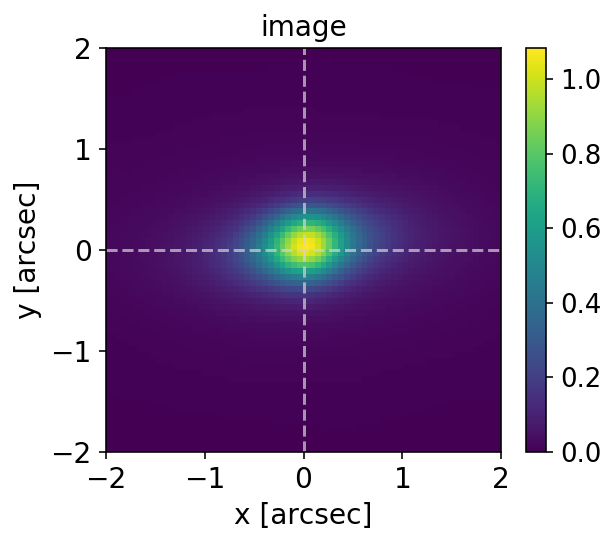

In [8]:
image0.display(xlim=[-2,2])

In [9]:
from imageFit import ImageFit
from tfCube2 import Parameters
from chainTool import ChainTool

par_init = Parameters(pars).fid
imgFit = ImageFit(image0, par_init=par_init)

In [10]:
chainImage_info = imgFit.run_MCMC(Nwalker=50, Nsteps=1000, active_par_key=['e_obs', 'r_hl_image', 'theta_int', 'flux'], par_fix={'g1':0., 'g2':0.})

100%|██████████| 1000/1000 [02:13<00:00,  7.47it/s]

Total MCMC time (mins): 2.2322915395100913


In [11]:
Chain_Image = ChainTool(chainImage_info, Nburn=25000, Nend=50000)

In [12]:
from chainconsumer import ChainConsumer

blue        = "#214F94"
red         = "#CC0204"
yellow      = "#FFA903"
gray        = "#858278"
black       = "#000000"
green       = "#73ab24"
purple      = "#8600C8"
lightblue   = "#6898FF"
lightblue2  = "#82b9e6"
yellowgreen = "#8dcd32" #"#8DE900"
lightteal   = "#7FC2BF"
teal        = "#51ABAE"
lightgray   = "#CDCDCD"

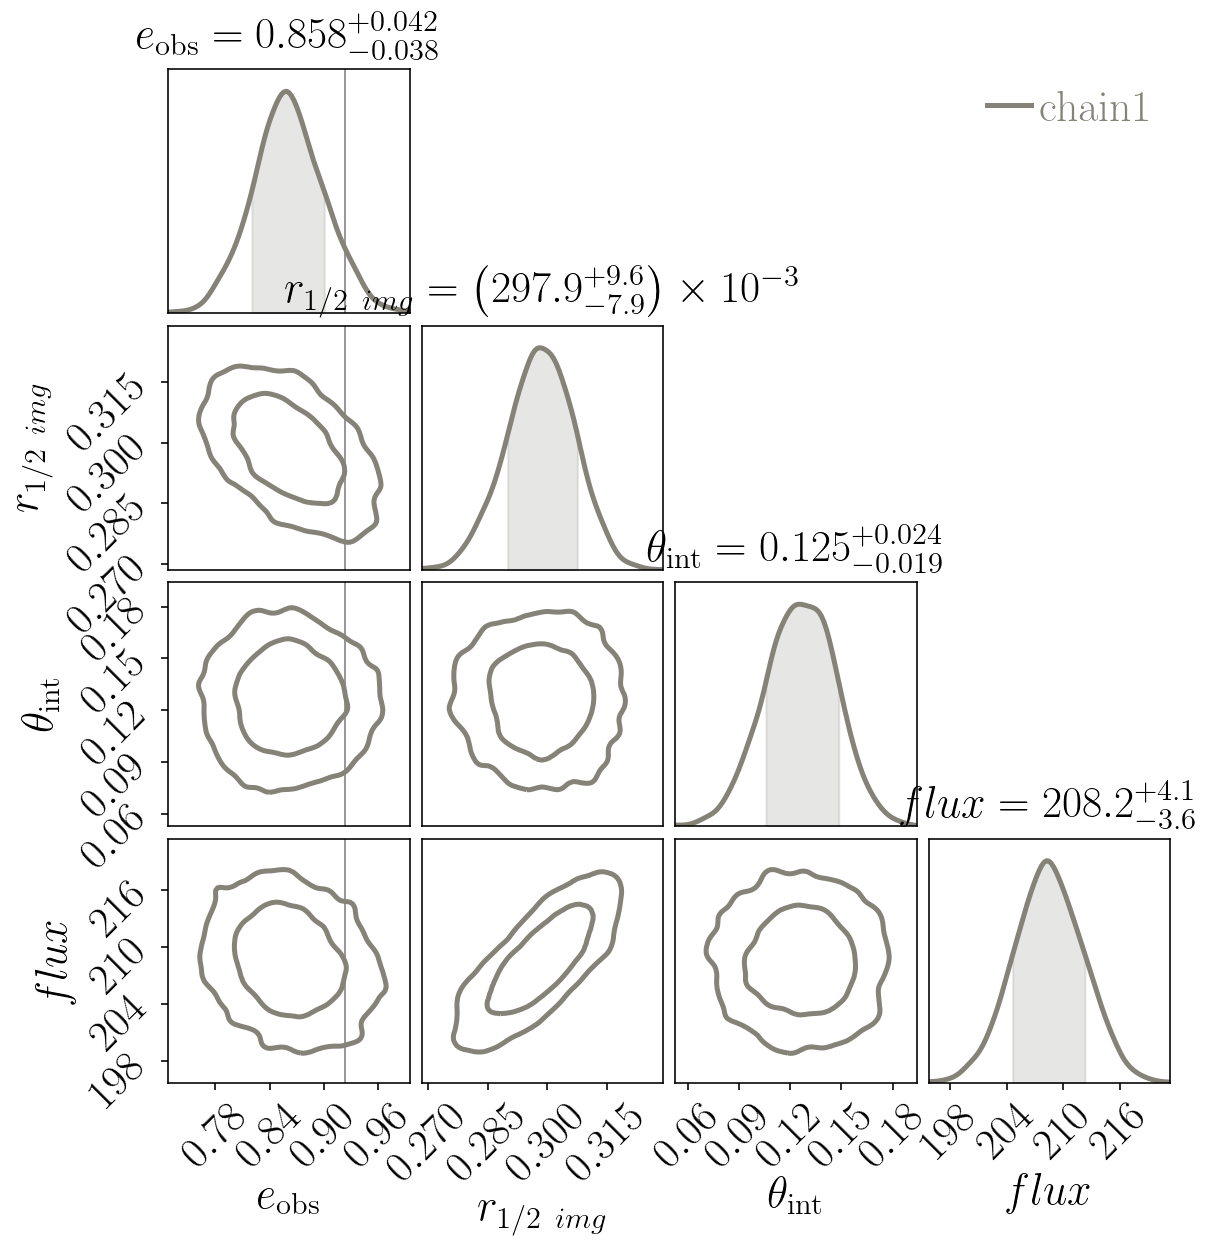

In [13]:
Nchains = 1
colors = [gray, lightblue, red, yellow, blue, yellowgreen, green, green, black]
lines = ["-", '--', "--", "-.", '-', ":", "--", ':']

statistics="max"

select_par_key = ['e_obs','r_hl_image','theta_int','flux']

parID1,parName1,par_x1 = Chain_Image.select_par_info(select_par_key)

c = ChainConsumer()
c.add_chain(Chain_Image.chain[:, parID1], parameters=parName1 ,name="$\mathrm{chain1}$")


c.configure(linewidths=2.5,sigmas=np.array([0,1,2]),bins=0.5,sigma2d=False,label_font_size=22,tick_font_size=22
            ,colors=colors
            ,shade=[False]*Nchains
            ,statistics=statistics,summary=True
            ,linestyles=lines
            ,shade_gradient=[0]*Nchains
            ,bar_shade=[True]*Nchains)


c.configure_truth(color="gray",lw=1,ls="-",alpha=0.8, zorder=-1)
truth_pt = [Chain_Image.par_fid[item] for item in imgFit.active_par_key]
fig = c.plotter.plot(legend=True, truth=truth_pt) #, truth=par_x1

fig.subplots_adjust(left=0.12, right=0.99, bottom=0.11, top=0.99)

fig.set_size_inches(2 + fig.get_size_inches())
fig.savefig("fig1.pdf", transparent=True)

In [14]:
Chain_Image.par_bestfit(select_par_key=['theta_int'], statistics='max', mode=0)

{'theta_int': [0.1063784104180526, 0.12189267916062223, 0.1480298707946225]}

### default auto mock generation

In [15]:
dataInfo = mock.gen_mock_data(noise_mode=0)

/Users/hhg/Research/kinematic_lensing/repo/TNGcube/notebooks/../../TNGcube/TNGcube.py:744: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


(<Figure size 324x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f89c198de90>)

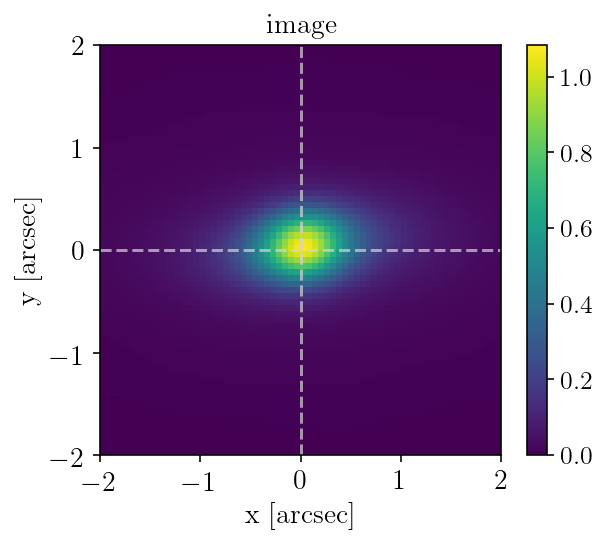

In [16]:
dataInfo['image'].display(xlim=[-2., 2.])

/Users/hhg/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:795: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


time cost in gaussFit_spec2D: 0.3961610794067383 (secs)


/Users/hhg/Research/kinematic_lensing/repo/TNGcube/notebooks/../../TNGcube/../BinnedFit/spec2D.py:216: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


(<Figure size 468x324 with 3 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f89c1971a10>)

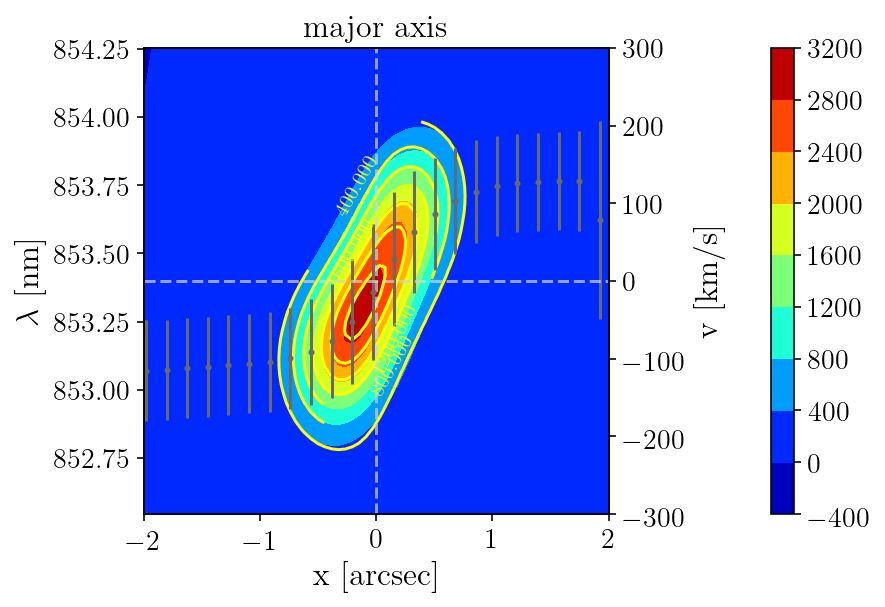

In [17]:
model_major = dataInfo['spec'][0].GF.model
dataInfo['spec'][0].display(xlim=[-2., 2], vlim=[-300, 300], mark_fit=True, model=model_major, title='major axis')

/Users/hhg/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:795: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


time cost in gaussFit_spec2D: 0.5202159881591797 (secs)


(<Figure size 468x324 with 3 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f89e0f1f090>)

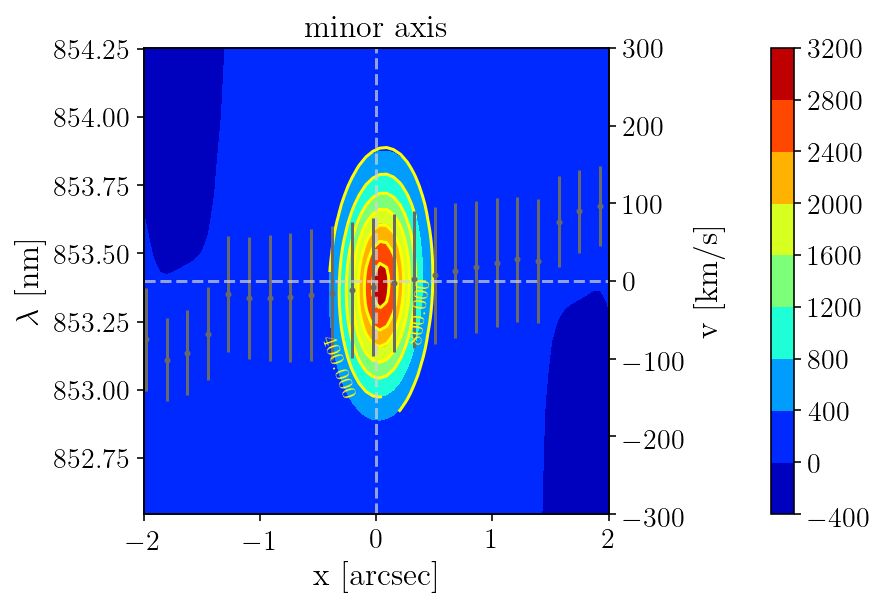

In [18]:
model_minor = dataInfo['spec'][1].GF.model
dataInfo['spec'][1].display(xlim=[-2., 2], vlim=[-300, 300], mark_fit=True, model=model_minor, title='minor axis')

time cost in gaussFit_spec2D: 0.06378984451293945 (secs)
time cost in gaussFit_spec2D: 0.08284211158752441 (secs)


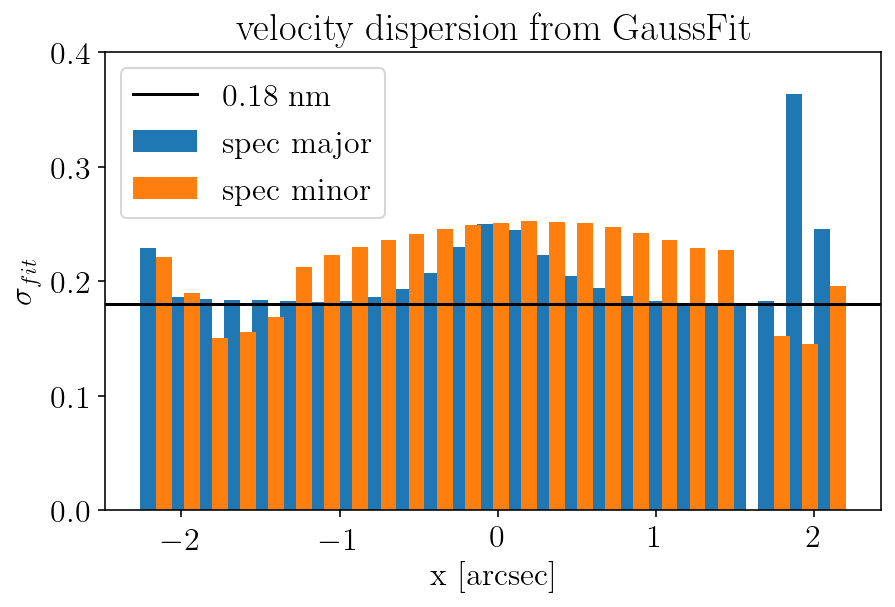

In [19]:
spec2D_0 = dataInfo['spec'][0].cutout(xlim=[-2.2, 2.2])
spec2D_1 = dataInfo['spec'][1].cutout(xlim=[-2.2, 2.2])
cenL0, amp0, sigma0 = spec2D_0.GF.fit_spec2D()
cenL1, amp1, sigma1 = spec2D_1.GF.fit_spec2D()

dj=3
x = spec2D_1.spaceGrid[::dj]
width = 0.1  # the width of the bars

fig, ax = plt.subplots(figsize=(6.5, 4.5))
bar0 = ax.bar(x - width/2, sigma0[::dj], width, label='spec major')
bar1 = ax.bar(x + width/2, sigma1[::dj], width, label='spec minor')

ax.axhline(y=0.18, color='k', label='0.18 nm')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('$\sigma_{fit}$')
ax.set_title('velocity dispersion from GaussFit')

ax.set_xlabel('x [arcsec]')

ax.set_ylim([0., 0.4])
ax.legend()

fig.tight_layout()

plt.show()

In [20]:
dataInfo['par_fid']

{'redshift': 0.3,
 'sini': 1.0,
 'theta_int': 0.0,
 'aspect': 0.2,
 'spinR': [0, 0, -1],
 'g1': 0.0,
 'g2': 0.0,
 'ngrid': 256,
 'image_size': 128,
 'pixScale': 0.1185,
 'nm_per_pixel': 0.033,
 'lambda_cen': 853.3993,
 'sigma_thermal': 16.0,
 'psfFWHM': 0.5,
 'psf_g1': 0.0,
 'psf_g2': 0.0,
 'Resolution': 5000.0,
 'slitWidth': 0.12,
 'expTime': 1800.0,
 'area': 785000.0,
 'throughput': 0.29,
 'ref_SDSS_peakI': 3e-17,
 'read_noise': 3.0,
 'slitAngles': [0.0, 1.5707963267948966],
 'ref_SDSS_lineL': 3e-17,
 'lineflux': 4.244131815783875e-17,
 'vcirc': 121.588,
 'r_hl_image': 0.5,
 'vscale': 0.5,
 'r_0': 0.0,
 'v_0': 0.0,
 'flux': 284.85464,
 'subGridPixScale': 0.05924999999999958}

## ------ For detailed debug: run through key methods of generating mock ------

In [21]:
par_meta = {}
# optimal par_meta for subhaloID=46, snap=75
#par_meta['theta'] = 15. *np.pi/180.
#par_meta['dx'] = [0.8,1.3,0]
#par_meta['dv'] = [0.0,0.,4.5]

par_meta['theta'] = 0. *np.pi/180.
par_meta['dx'] = [0.,0.,0.]
par_meta['dv'] = [0.0,0.,0.]

mock = TNGmock(pars=pars, subhalo=subhalo, par_meta=par_meta)

In [22]:
# 3. generate specCube
#massCube = mock.gen_massCube(ptlTypes=['gas', 'stars'], lineTypes=mock.line_species, weights='mass')
#massCube = mock.gen_massCube(ptlTypes=['gas'], lineTypes=mock.line_species, weights='mass')
massCube = mock.gen_massCube(ptlTypes=['gas'], lineTypes=mock.line_species, weights='SFR')
mock.specCube = mock.mass_to_light(massCube)

# 3.1 add psf for each plan at lambdaGrid[i]
#mock.specCube.add_psf(psfFWHM=mock.Pars.fid['psfFWHM'], psf_g1=mock.Pars.fid['psf_g1'], psf_g2=mock.Pars.fid['psf_g2'])

# 3.2 smooth spectrum
    # thermal part
mock.sigma_thermal_nm = mock.cal_sigma_thermal_nm(sigma_thermal_kms=mock.Pars.fid['sigma_thermal'])
    # spectral resoultion part
mock.sigma_resolution_nm = mock.Pars.fid['lambda_cen']/mock.Pars.fid['Resolution']
mock.sigma_tot = np.sqrt(mock.sigma_thermal_nm**2 +  mock.sigma_resolution_nm**2)
mock.specCube.add_spec_sigma_approx(sigma=mock.sigma_tot)
#mock.specCube.add_spec_sigma(resolution=mock.Pars.fid['Resolution'], sigma_thermal_nm=mock.sigma_thermal_nm)

# 3.3 flux renormalization
mock.specCube = mock.flux_renorm(mock.specCube)

In [23]:
spectra = Slit(mock.specCube, slitWidth=mock.Pars.fid['slitWidth']).get_spectra(slitAngles=mock.Pars.fid['slitAngles'])

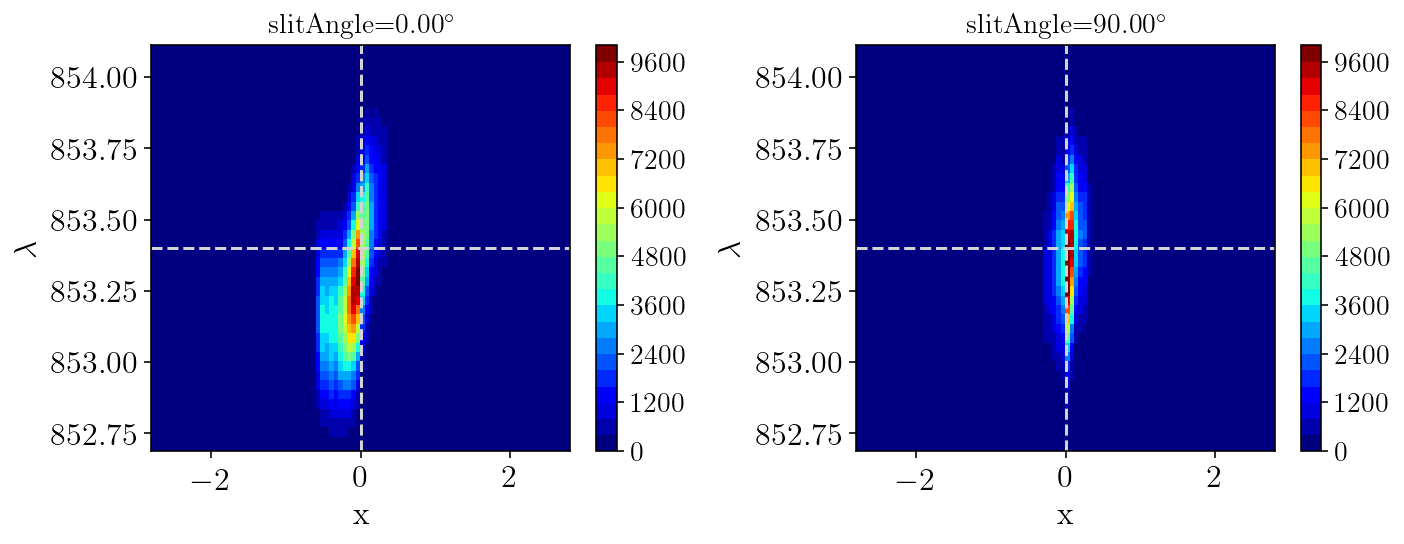

sigma_thermal: 0.046 [nm]       (16.00 km/s)
sigma_resolution: 0.171 [nm]    (59.96 km/s)
sigma_tot: 0.177 [nm]           (62.06 km/s)


In [24]:
vlim = [-250, 250]
ylim = velocity_to_lambda(vlim, mock.lambda0, mock.z)
plot_specs(spectra, slitAngles=mock.Pars.fid['slitAngles'], 
           spaceGrid=mock.Pars.spaceGrid, lambdaGrid=mock.Pars.lambdaGrid, xlim=[-2.8, 2.8], ylim=ylim)


# print information
sigma_thermal_kms = mock.Pars.fid['sigma_thermal']
print(f'sigma_thermal: {mock.sigma_thermal_nm:.3f} [nm]       ({sigma_thermal_kms:.2f} km/s)')

sigma_resolution_kms = mock.sigma_resolution_nm/mock.Pars.fid['lambda_cen']*mock.c_kms
print(f'sigma_resolution: {mock.sigma_resolution_nm:.3f} [nm]    ({sigma_resolution_kms:.2f} km/s)')

sigma_tot_kms = mock.sigma_tot/mock.Pars.fid['lambda_cen']*mock.c_kms
print(f'sigma_tot: {mock.sigma_tot:.3f} [nm]           ({sigma_tot_kms:.2f} km/s)')

/Users/hhg/Research/kinematic_lensing/repo/TNGcube/notebooks/../../TNGcube/TNGcube.py:744: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


(<Figure size 324x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f89e1035390>)

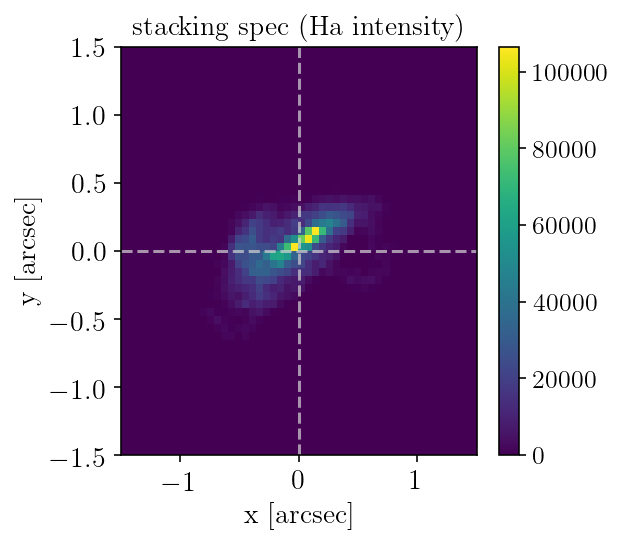

In [25]:
# 3 ways of generating mock image

#    - 1. image based on band photometry
band = 'V'
#imageArr = mock.gen_imageArray(band=band, weights='photometry')

#    - 2. image based on particle weights
#imageArr = mock.gen_imageArray(weights='mass')

#image = Image(imageArr, mock.Pars.spaceGrid)

#    -3. image based on Line information (by stacking specCube)
image = Image(mock.specCube)

# add psf
#image.add_psf(psfFWHM=mock.Pars.fid['psfFWHM'], psf_g1=mock.Pars.fid['psf_g1'], psf_g2=mock.Pars.fid['psf_g2'])

# add noise (or not)
#image.array_var = image.gen_image_variance(signal_to_noise=100., add_noise=True)

#title = f'{band} band photometry'
#title = 'star ptl. mass weighted'
title = 'stacking spec (Ha intensity)'
image.display(xlim=[-1.5,1.5], title=title)